In [1]:
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels as sm
import statsmodels.api as smapi
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from pmdarima.arima import ndiffs, nsdiffs
import warnings
warnings.filterwarnings("ignore")

# Load data

In [2]:
DB_URI="sqlite:///C:/Users/User/Desktop/MBD/Term2/PythonII/Group_Assignment/data/processed/database_energy.db"

engine=create_engine(DB_URI)

energy_df=pd.read_sql_table("final_data",engine)

energy_df.set_index('date', inplace=True)

target = 'price actual'

y = energy_df[target]

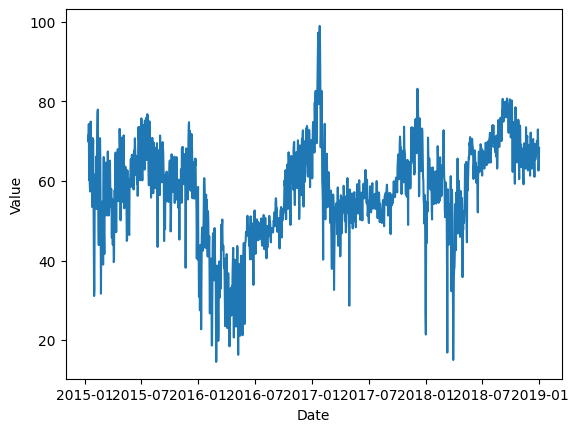

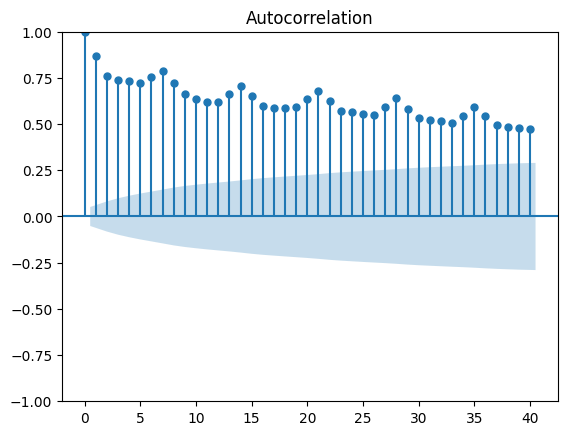

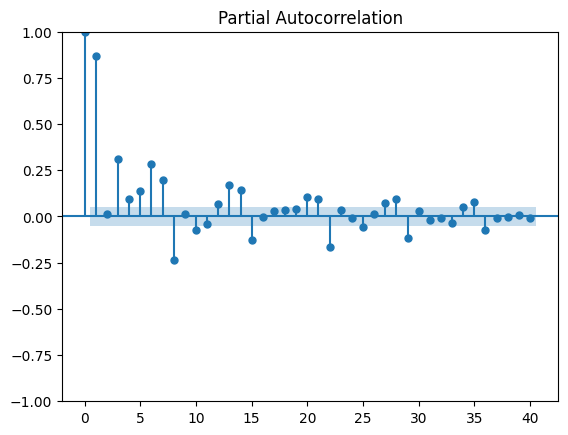

In [12]:
# Plot the time series
plt.plot(y)
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Plot the ACF and PACF
plot_acf(y, lags=40)
plt.show()
plot_pacf(y, lags=40)
plt.show()

In [22]:
# Perform the ADF test for stationarity
adf_result = sm.tsa.stattools.adfuller(y,maxlag=10)
print(f'ADF test: coeficient ={adf_result[0]} p_value = {adf_result[1]}')

# Perform the Shapiro test for normality
shapiro_result = normal_ad(y)
print(f'Shapiro test: coeficient ={shapiro_result[0]} p_value = {shapiro_result[1]}')

# Perform the Box test for normality of the residuals
box_result = smapi.stats.acorr_ljungbox(y, lags=[25])
print('Box test:', box_result)

ADF test: coeficient =-4.249526778152863 p_value = 0.0005426279718338285
Shapiro test: coeficient =7.081236898721272 p_value = 2.5182277537067998e-17
Box test:          lb_stat  lb_pvalue
25  16430.109951        0.0


In [26]:
from scipy.stats import kurtosis, skew

# Basic statistics
mean = np.mean(y)
std = np.std(y)
kurtosis = kurtosis(y)
skewness = skew(y)

print("Mean",mean,"Standard deviation",std,"Skewness", skewness, "Kurtosis",kurtosis)

Mean 57.85520571110244 Standard deviation 12.081019168164195 Skewness -0.5454055654033331 Kurtosis 0.7988786496019982


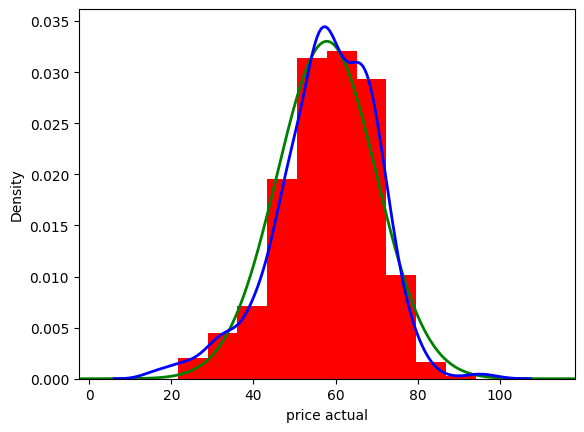

In [40]:
import scipy.stats as st

mu = np.mean(y)
sigma = np.std(y)
x = np.linspace(mu -5*sigma, mu +5*sigma, 1000)
pdf = st.norm.pdf(x, mu, sigma)
ax = plt.plot(x, pdf, lw = 2, color = "g")
ax = plt.hist(y,density=True, range = (mean - 3*std, mean + 3*std), color = "r")
ax = sns.distplot(y, hist = False, kde = True,
                 kde_kws = {'linewidth': 2}, color = "blue")
ax.set_xlim(mean - 5*std, mean + 5*std)

plt.show()

## SARIMA

In [41]:
# Tests
s = 12
d = ndiffs(y, alpha = 0.05, test='adf')  # regular differences
D = nsdiffs(y, m = s, test='ocsb') # # seasonal differences

print("Regular differences: ", d)
print('Seasonal differences:', D)

Regular differences:  0
Seasonal differences: 0


In [46]:
import itertools
import statsmodels.api as sm

# Define the ranges for the parameters p, d, and q
p = d = q = range(0, 3)

# Generate all possible combinations of the parameters p, d, and q
pdq = list(itertools.product(p, d, q))

# Generate all possible combinations of the seasonal parameters P, D, and Q
seasonal_pdq = [(x[0], x[1], x[2], s) for x in pdq]

# Initialize variables to store the best AIC and corresponding parameters
best_aic = float("inf")
best_params = None

# Iterate through all possible parameter combinations
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            # Fit SARIMA model with current parameter combination
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            # Update best AIC and parameters if current AIC is lower
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, param_seasonal)
        except:
            continue

# Print the best SARIMA parameters and corresponding AIC
print("Best SARIMA parameters:", best_params)
print("Best AIC:", best_aic)

Best SARIMA parameters: ((1, 0, 2), (1, 1, 2, 7))
Best AIC: 8306.433283890536


                                     SARIMAX Results                                     
Dep. Variable:                      price actual   No. Observations:                 1450
Model:             SARIMAX(1, 0, 2)x(1, 1, 2, 7)   Log Likelihood               -4211.202
Date:                           Sun, 10 Mar 2024   AIC                           8436.404
Time:                                   17:56:15   BIC                           8473.325
Sample:                               01-12-2015   HQIC                          8450.185
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9773      0.006    162.430      0.000       0.966       0.989
ma.L1         -0.2020      0.018    -10.966

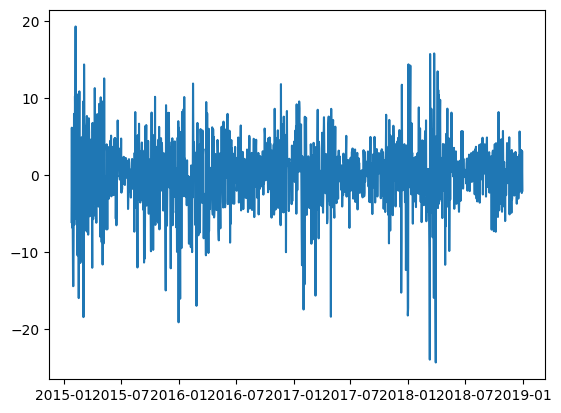

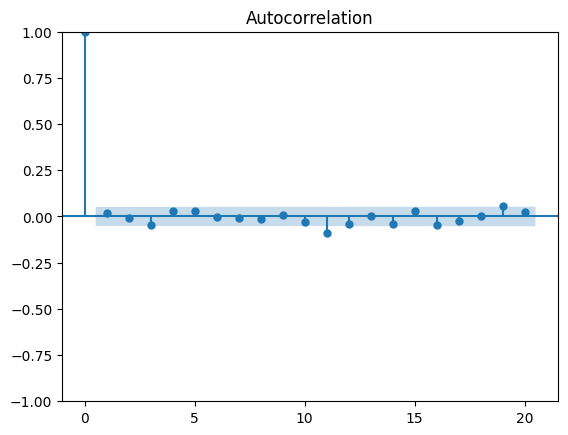

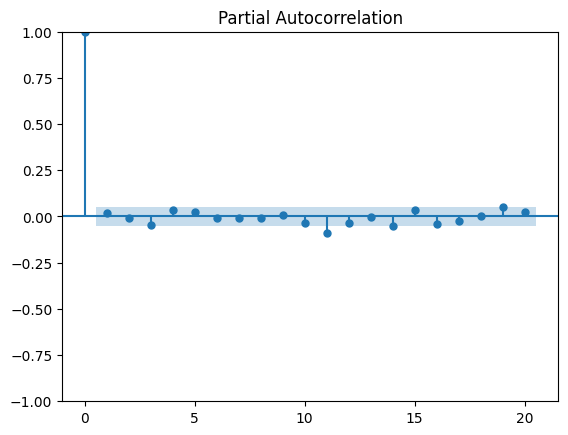

In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

s = 7

sar_model1 = SARIMAX(endog = y, order = (1,0,2), seasonal_order = (1,1,2,s)).fit()
print(sar_model1.summary())
residuals = sar_model1.resid[13:]

nlags=20

plt.plot(residuals)
plt.show()
plot_acf(residuals, lags = nlags)
plt.show()
plot_pacf(residuals, method="ols", lags = nlags)
#plot_pacf(residuals,lags = nlags)
plt.show()

In [49]:
d = ndiffs(residuals, alpha = 0.05, test='adf')  # regular differences?
D = nsdiffs(residuals, m = s, test='ocsb') # # seasonal differences?

print("Regular differences: ", d)
print('Seasonal differences:', D)

Regular differences:  0
Seasonal differences: 0


Ljung-Box for the residuals
      lb_stat  lb_pvalue
25  41.627926   0.019699
Shapiro test for residuals: Statistic value 0.9572937380492934 p-value 4.3407421805538576e-20


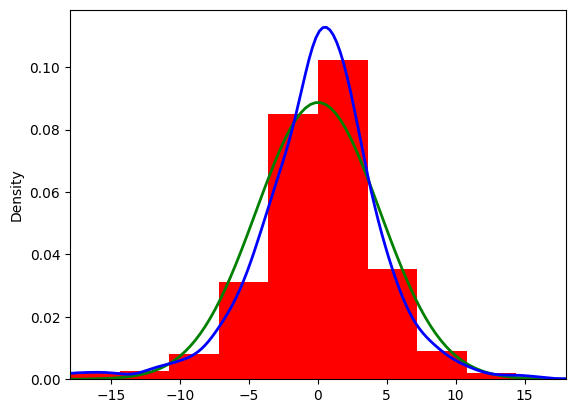

In [50]:
# Box test for autocorrelations

import statsmodels.api as sm
box_test = sm.stats.acorr_ljungbox(residuals, lags=[25])

print("Ljung-Box for the residuals")
print(box_test)

from scipy.stats import shapiro
import seaborn as sns
import scipy.stats as st

# Normalitresiduos test

saphiro = shapiro(residuals)
print("Shapiro test for residuals: Statistic value", saphiro[0],"p-value",saphiro[1]) # first output "The test statistic", second output "p-value"

mean = np.mean(residuals)
std = np.std(residuals)
mu = np.mean(residuals)
sigma = np.std(residuals)
x = np.linspace(mu -4*sigma, mu +4*sigma, 100)
pdf = st.norm.pdf(x, mu, sigma)
ax = plt.plot(x, pdf, lw = 2, color = "g")
ax = plt.hist(residuals,density=True, range = (mean - 4*std, mean + 4*std), color = "r")
ax = sns.distplot(residuals, hist = False, kde = True,
                 kde_kws = {'linewidth': 2}, color = "blue")
ax.set_xlim(mean - 4*std, mean + 4*std)


plt.show()

Ljung-Box for squared residuals
       lb_stat     lb_pvalue
20  485.420835  3.270222e-90


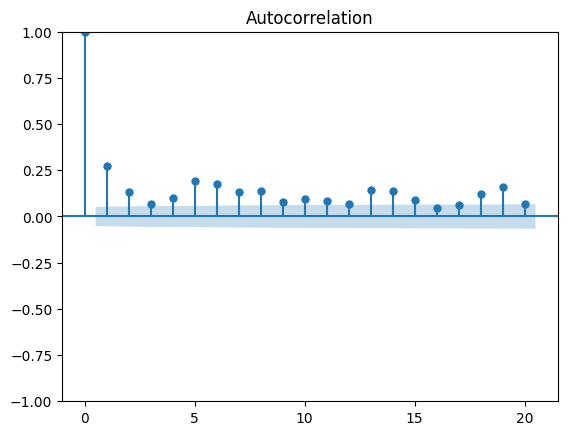

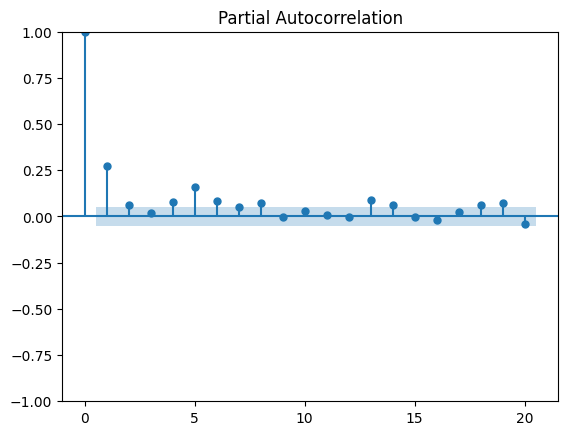

In [52]:
box_test2 = sm.stats.acorr_ljungbox(residuals**2, lags=[20])
print("Ljung-Box for squared residuals")
print(box_test2)

plot_acf(residuals**2,lags=nlags)
plt.show()
plot_pacf(residuals**2,lags=nlags,method="ols")
plt.show()

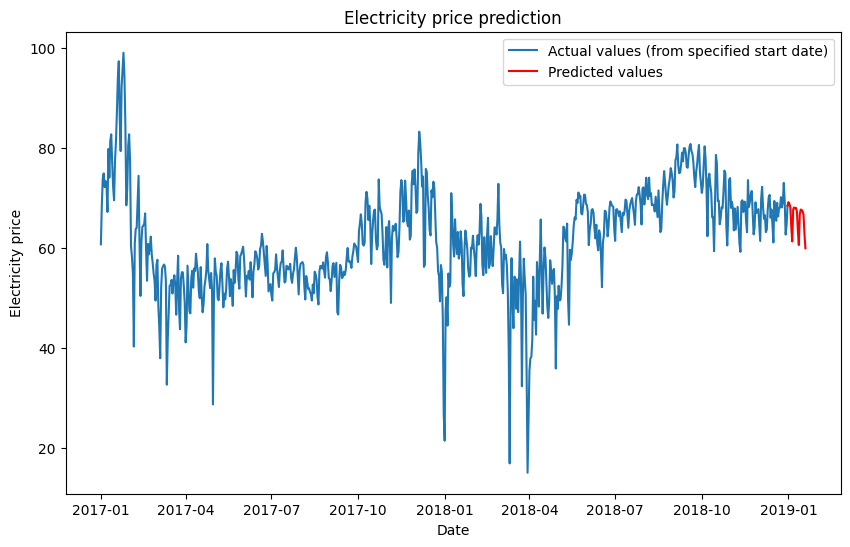

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming 'y' is your time series data of electricity prices with dates as index

# Set the start date for your time series (e.g., '2017-01-01')
start_date = '2017-01-01'

# Filter data from the specified start date onwards
y_from_start_date = y[start_date:]

# Fit SARIMA model to historical data from the specified start date onwards
s = 7
sar_model1 = SARIMAX(endog=y_from_start_date, order=(1, 0, 2), seasonal_order=(1, 1, 2, s)).fit()

# Make predictions for the next 20 days
forecast = sar_model1.forecast(steps=20)

# Create dates for the next 20 days (assuming you have dates for historical data)
last_date = y.index[-1]
date_range = pd.date_range(start=last_date, periods=20, freq='D')

# Visualize actual values from the specified start date onwards and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_from_start_date.index, y_from_start_date, label='Actual values (from specified start date)')
plt.plot(date_range, forecast, label='Predicted values', color='red')
plt.title('Electricity price prediction')
plt.xlabel('Date')
plt.ylabel('Electricity price')
plt.legend()
plt.show()
